# Neural Network tuning

## Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint



#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
#from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
#from sklearn.metrics import precision_recall_curve, average_precision_score


In [2]:
from modules.data_exploration.data_ex import import_data, gen_bulk_data, get_bulk_inst
from modules.build_ml_models.NN_classification import build_model, plot_confusion_matrix, print_classification_report

## Load data

In [3]:
file_path = 'data/churn.csv'
data_dict = gen_bulk_data(file_path)
data_dict.keys()

dict_keys(['original', 'dropped', 'scaled', 'encoded', 'encoded and scaled', 'scaled and dropped'])

In [4]:
key = 'original'

x_train, x_test, x_val, y_train, y_test, y_val = get_bulk_inst(data_dict, key)

In [5]:
#x_train.drop(columns=['index'], inplace=True)
#x_test.drop(columns=['index'], inplace=True)
x_train

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,42,45,415,1754,1,0,0,189.6,96,32.23,171.7,69,14.59,222.0,102,9.99,13.9,7,3.75,1
1,16,33,415,3987,0,0,0,228.1,77,38.78,176.3,102,14.99,224.5,119,10.10,7.5,1,2.03,0
2,0,104,408,2029,0,0,0,278.4,106,47.33,81.0,113,6.89,163.2,137,7.34,9.8,5,2.65,1
3,42,78,415,257,0,0,0,149.7,119,25.45,182.2,115,15.49,261.5,126,11.77,9.7,8,2.62,0
4,13,92,415,3485,0,0,0,197.2,113,33.52,242.3,116,20.60,192.0,76,8.64,11.0,5,2.97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,37,101,415,3713,0,0,0,118.6,89,20.16,199.6,97,16.97,53.3,61,2.40,11.5,5,3.11,1
3496,23,101,415,1811,0,0,0,183.9,115,31.26,255.9,101,21.75,275.0,145,12.38,10.8,11,2.92,1
3497,50,33,415,181,0,0,0,213.9,88,36.36,239.8,119,20.38,148.7,71,6.69,9.8,14,2.65,2
3498,32,158,408,2570,0,0,0,172.4,114,29.31,256.6,69,21.81,235.3,104,10.59,0.0,0,0.00,2


In [6]:
y_test

0      0
1      0
2      0
3      1
4      0
      ..
745    0
746    0
747    0
748    0
749    1
Name: class, Length: 750, dtype: int64

In [7]:
#from keras.utils import to_categorical 
#import numpy as np

#y_train_cat = to_categorical(y_train)

#type(y_train_cat)
#print(y_train_cat.shape)
#print(x_train.shape)



#for i in range(len(y_train_cat)):
#    print(y_train_cat[i])


# Build model

## Model with best RECALL

In [8]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_rec = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_rec.summary()

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


model_rec.compile(
    loss='binary_crossentropy',
    #loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0005),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives()])

In [9]:
epo = 200

CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='recall_model.hdf5', save_best_only=True, mode='max', verbose=0)


history_rec = model_rec.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

In [10]:
# Load best recall modell
model_rec.load_weights('recall_model.hdf5')

model_rec.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.5080 - accuracy: 0.7987 - precision: 0.3729 - recall: 0.6226


[0.5079769492149353,
 0.7986666560173035,
 0.37288135290145874,
 0.6226415038108826]

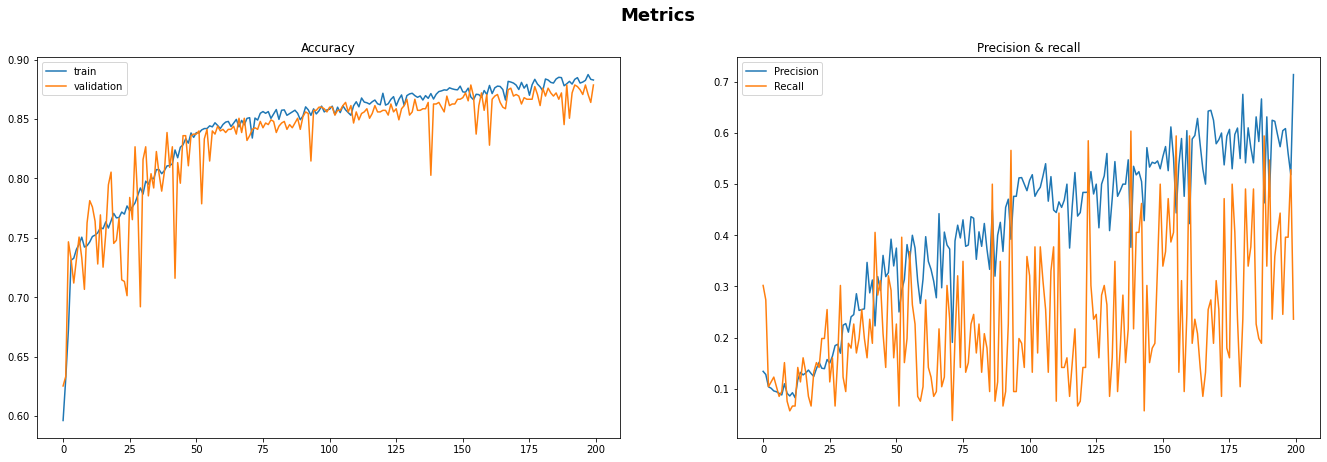

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23, 7))

ax1.plot(history_rec.history['accuracy'], label='train')
ax1.plot(history_rec.history['val_accuracy'], label='validation')
ax1.set_title('Accuracy')
ax2.plot(history_rec.history['val_precision'], label='Precision')
ax2.plot(history_rec.history['val_recall'], label='Recall')
ax2.set_title('Precision & recall')
#ax2.plot(history.history['val_true_positives'], label='True positives')

plt.suptitle('Metrics', fontsize=18, fontweight='bold')
ax1.legend()
ax2.legend()
plt.show()

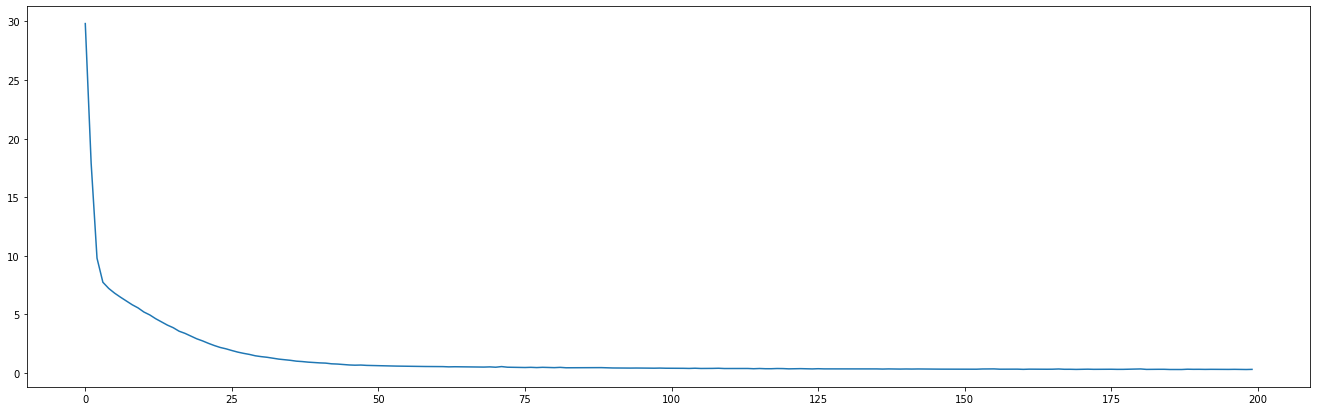

Min loss: 0.30298367142677307


In [12]:
plt.figure(figsize=(23,7))

plt.plot(history_rec.history['loss'], label='loss')
plt.show()
print('Min loss:',min(history_rec.history['loss']))

In [13]:
y_pred = model_rec.predict(x_test)
#y_pred

In [14]:
import numpy as np

threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)



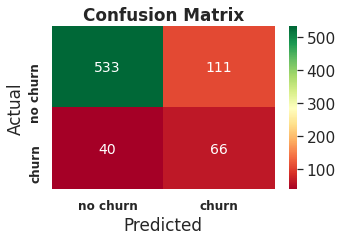


Classification report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       644
           1       0.37      0.62      0.47       106

    accuracy                           0.80       750
   macro avg       0.65      0.73      0.67       750
weighted avg       0.85      0.80      0.82       750



In [15]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)

In [16]:
print_classification_report(y_test, y_pred)


Classification report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       644
           1       0.37      0.62      0.47       106

    accuracy                           0.80       750
   macro avg       0.65      0.73      0.67       750
weighted avg       0.85      0.80      0.82       750



epochs = 20



model = Sequential()
model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_shape,), activation='relu' ))
model.add(Dropout(rate=0.4))
model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(x_train.shape[0]/32)*5,
      decay_rate=1,
      staircase=False)

#This time decay means for every 5 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]


model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    

    
    
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=get_callbacks())#, verbose=0)

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##  Model with best PRECISION

In [17]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_pre = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_pre.summary()

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [18]:
epo = 200

CB_checkpoint = ModelCheckpoint(monitor='val_precision', filepath='precision_model.hdf5', save_best_only=True, mode='max',verbose=0)


history_pre = model_pre.fit(x_train, y_train, epochs=epo, validation_data=(x_val, y_val), callbacks=[CB_checkpoint], verbose=0)

In [19]:
# Load best recall modell
model_pre.load_weights('precision_model.hdf5')

model_pre.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8653 - precision: 0.5581 - recall: 0.2264    


[0.41541942954063416,
 0.8653333187103271,
 0.5581395626068115,
 0.22641509771347046]

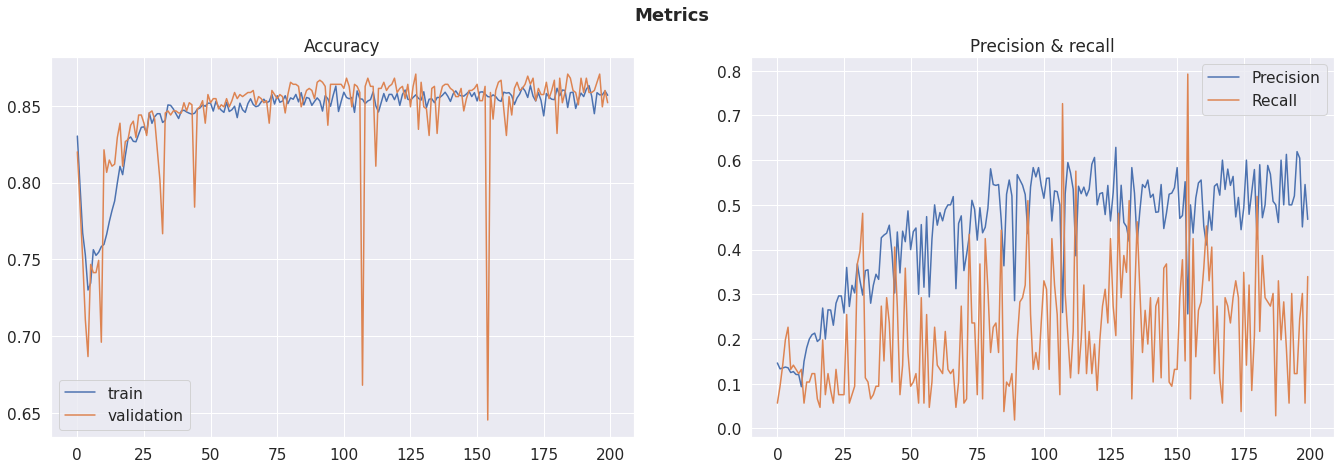

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23, 7))

ax1.plot(history_pre.history['accuracy'], label='train')
ax1.plot(history_pre.history['val_accuracy'], label='validation')
ax1.set_title('Accuracy')
ax2.plot(history_pre.history['val_precision'], label='Precision')
ax2.plot(history_pre.history['val_recall'], label='Recall')
ax2.set_title('Precision & recall')


plt.suptitle('Metrics', fontsize=18, fontweight='bold')
ax1.legend()
ax2.legend()
plt.show()

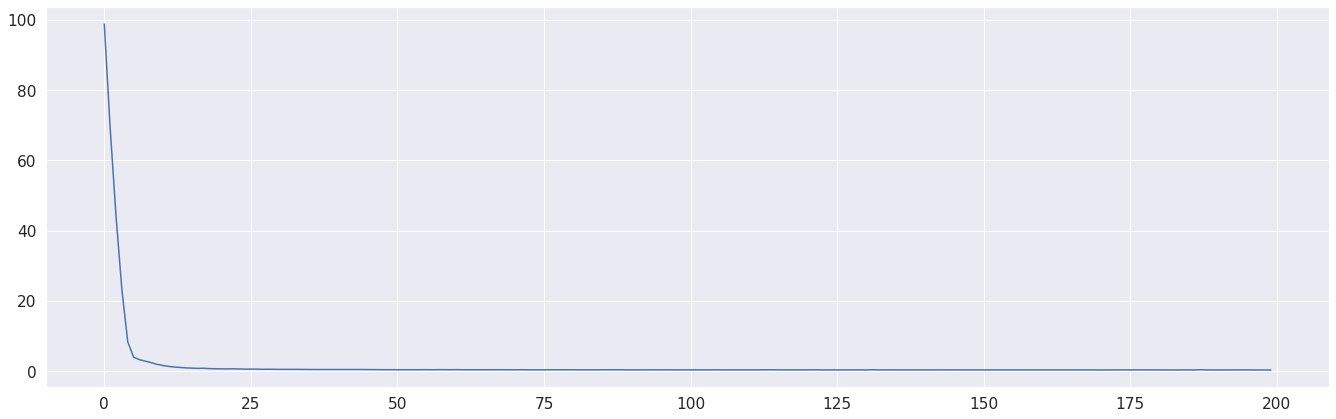

Min loss: 0.35928264260292053


In [21]:
plt.figure(figsize=(23,7))

plt.plot(history_pre.history['loss'], label='loss')
plt.show()
print('Min loss:',min(history_pre.history['loss']))

In [22]:
y_pred = model_pre.predict(x_test)
#y_pred

In [23]:
threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)

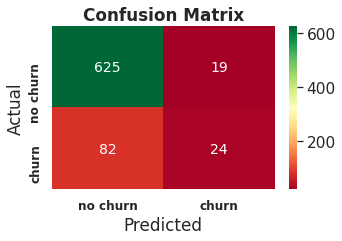


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750



In [24]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)

# ONE hidden layer - hidden size tuning

 === Hidden layer size: 2 ===


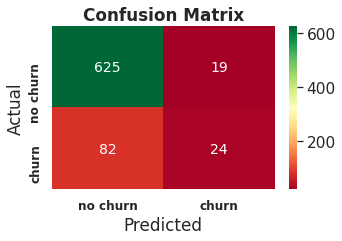


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 4 ===


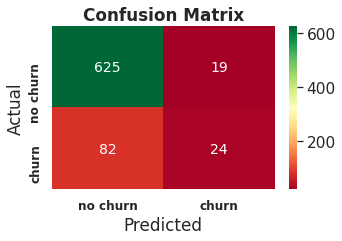


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 8 ===


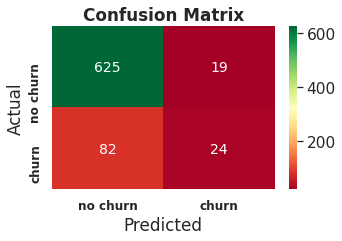


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 16 ===


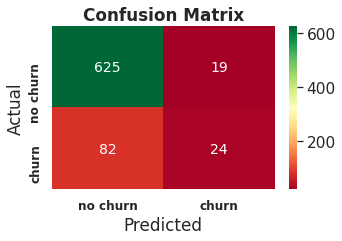


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 32 ===


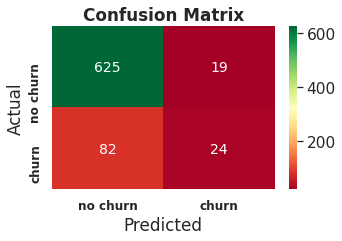


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 64 ===


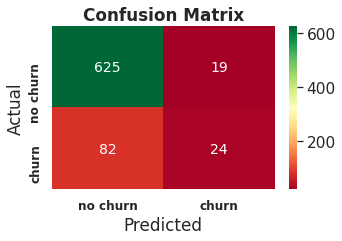


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 128 ===


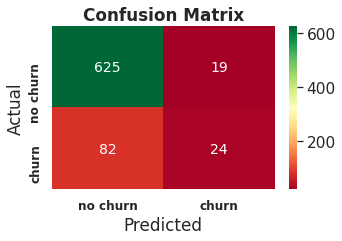


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 256 ===


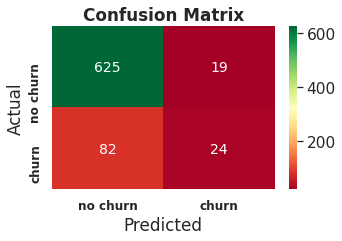


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 512 ===


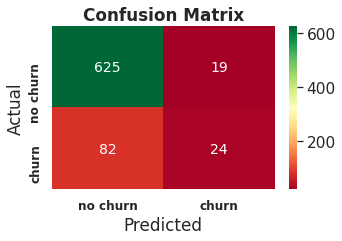


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 1024 ===


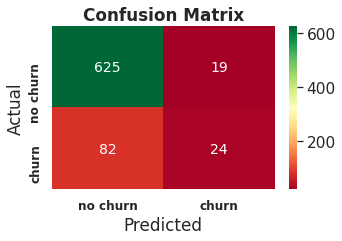


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: 2048 ===


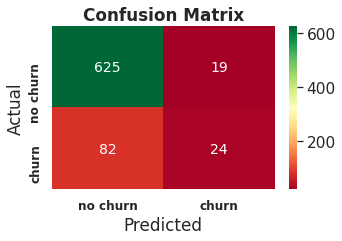


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750



In [26]:
epochs = 100

scores_hidden_dict = dict()

for hidden_shape in [2,4,8,16,32,64,128,256,512,1024,2048]:
    print(" === Hidden layer size:", hidden_shape, "===")

    scores = list()
    optimizer= Adam(0.0001)

    model_hidden = build_model(input_shape=20, hidden_shapes=[hidden_shape], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

    CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='one_lay_rec_model.hdf5', save_best_only=True, mode='max', verbose=0)
    
    hist = model_hidden.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0, callbacks=[CB_checkpoint])
    #scores_hidden_dict[hidden_shape] = hist.history['accuracy']
    model_hidden.load_weights('one_lay_rec_model.hdf5')

    
    y_pred = model_pre.predict(x_test)
    threshold = 0.5
    y_pred = np.where(y_pred<=threshold, 0, 1)
    
    plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
    print_classification_report(y_test, y_pred)
    del model_hidden

# Number of hidden layer tuning

In [27]:
# Number of hidden layers

from itertools import combinations_with_replacement, product
from random import sample

# initial set of layer size
x = [8, 16, 32, 64, 128]

# create combinations
c_2 = product(x, repeat=2) # 2 hidden layers
c_3 = product(x, repeat=3) # 3 hidden layers
c_4 = product(x, repeat=4) # 4 hidden layers
c_5 = product(x, repeat=5) # 5 hidden layers


# take 40 random combinations
c_2_sample = sample(list(c_2), 10)
c_3_sample = sample(list(c_3), 10)
c_4_sample = sample(list(c_4), 10)
c_5_sample = sample(list(c_5), 10)

test_comb = c_2_sample + c_3_sample + c_4_sample + c_5_sample

print(f" {len(test_comb)} test combinations chosen:\n{test_comb}")

 40 test combinations chosen:
[(128, 32), (8, 32), (8, 16), (64, 8), (32, 32), (16, 64), (32, 128), (8, 64), (64, 16), (8, 8), (32, 64, 64), (128, 128, 8), (128, 16, 32), (32, 128, 128), (32, 64, 128), (32, 8, 128), (8, 16, 16), (64, 128, 64), (128, 16, 16), (64, 128, 128), (32, 8, 8, 32), (8, 8, 16, 16), (64, 128, 32, 8), (8, 8, 128, 128), (16, 128, 128, 32), (16, 16, 8, 16), (32, 8, 128, 64), (128, 64, 64, 8), (16, 16, 32, 128), (32, 128, 8, 128), (16, 8, 8, 16, 8), (128, 64, 8, 32, 64), (8, 64, 8, 32, 8), (128, 128, 128, 16, 128), (128, 8, 8, 64, 8), (32, 64, 8, 8, 128), (8, 16, 128, 16, 16), (16, 64, 8, 16, 32), (128, 64, 64, 128, 32), (16, 16, 16, 128, 16)]


 === Hidden layer size: (128, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________


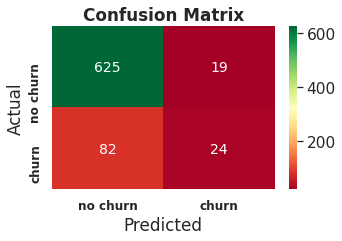


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

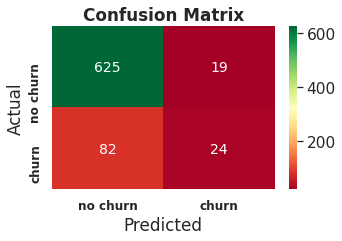


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

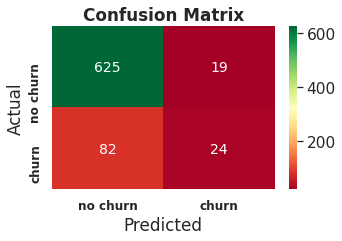


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

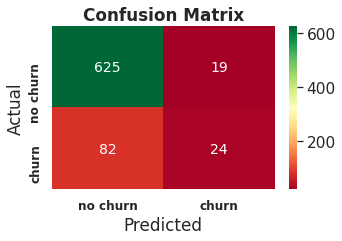


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

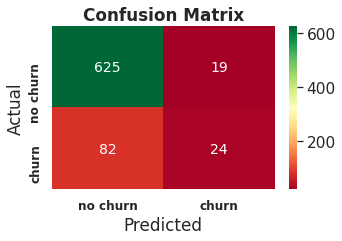


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

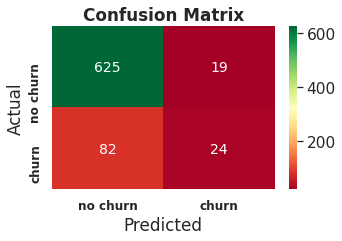


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)           

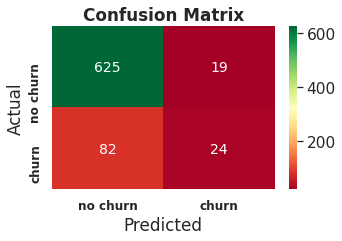


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

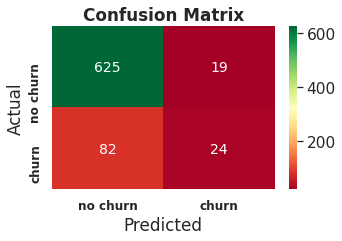


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

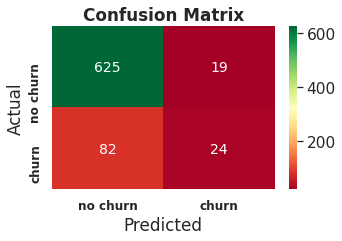


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)              

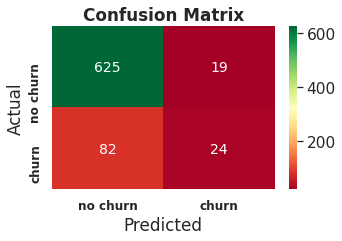


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 64, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                2112      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)       

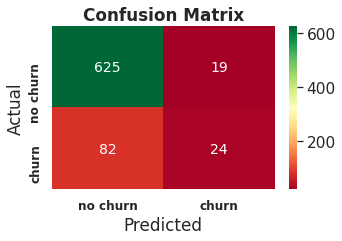


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 128, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)       

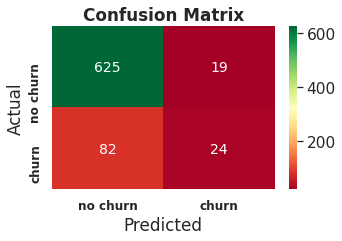


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 16, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                2064      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)      

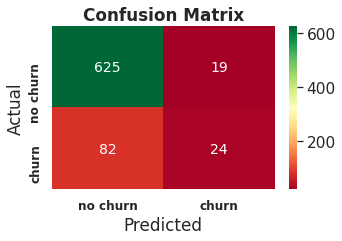


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 128, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               4224      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)    

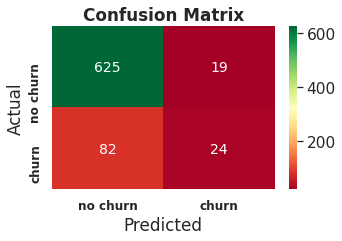


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 64, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                2112      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)     

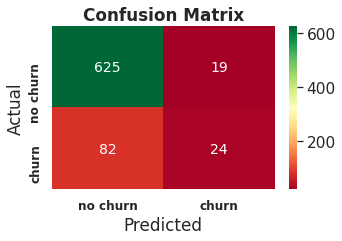


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 8, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 264       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)      

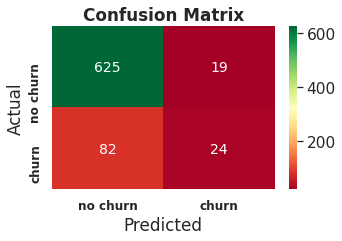


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)        

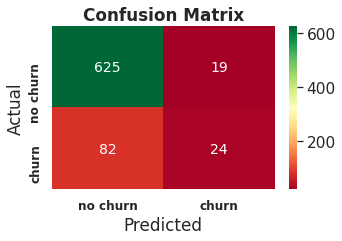


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 128, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)      

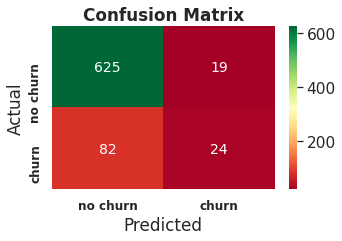


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                2064      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)      

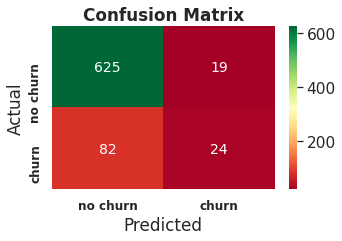


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 128, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)    

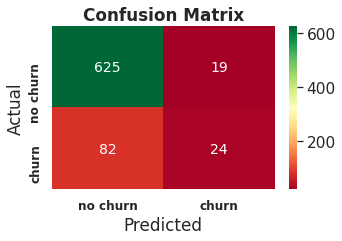


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 8, 8, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 264       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)      

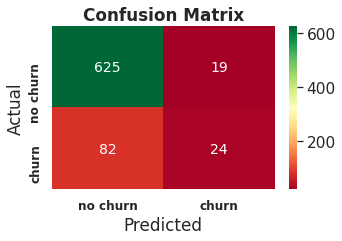


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 8, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 16)     

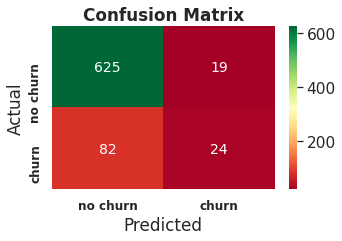


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (64, 128, 32, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 64)                1344      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               8320      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)   

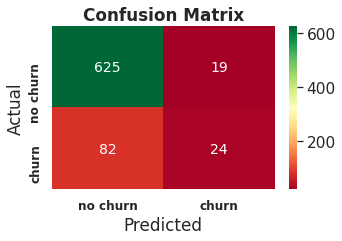


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 8, 128, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 72        
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)  

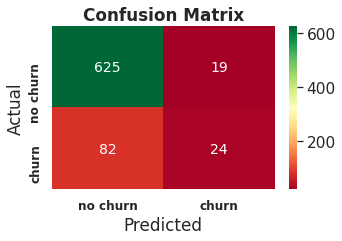


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 128, 128, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               2176      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)

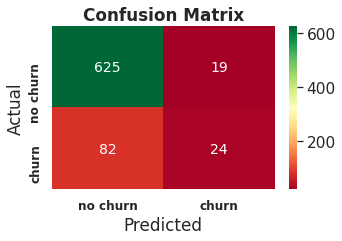


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 16, 8, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                272       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)     

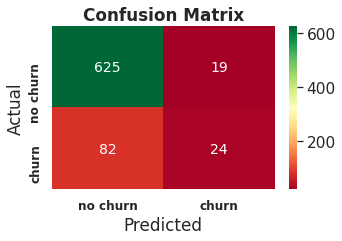


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 8, 128, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 264       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 128)  

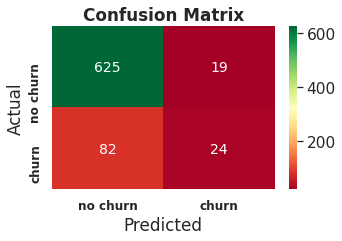


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 64, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 64)   

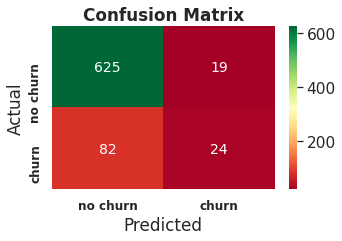


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 16, 32, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                272       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 32)  

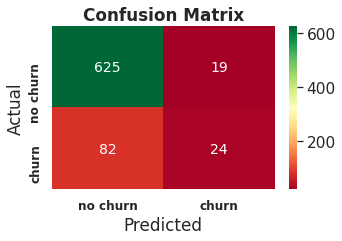


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 128, 8, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               4224      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)   

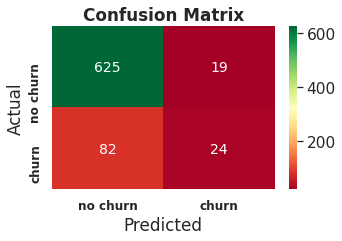


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 8, 8, 16, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 136       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)   

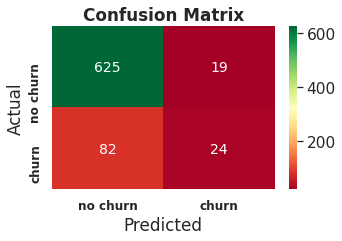


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 8, 32, 64) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)

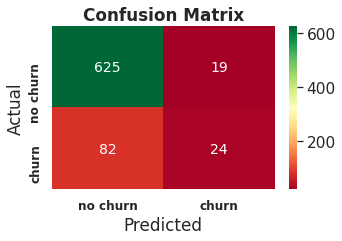


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 64, 8, 32, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                576       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)   

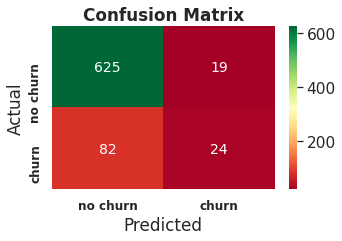


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 128, 128, 16, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_dense_3 (Dense)       (None

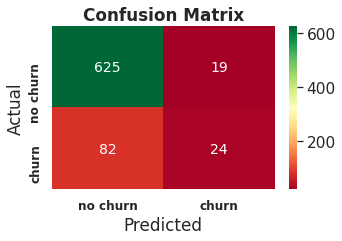


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 8, 8, 64, 8) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 8)                 1032      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8)  

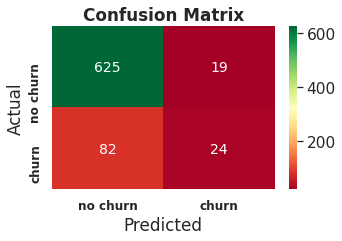


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (32, 64, 8, 8, 128) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                2112      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8) 

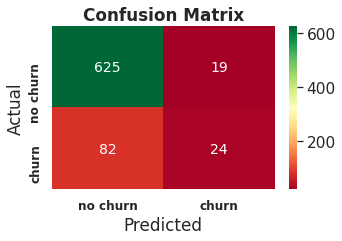


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (8, 16, 128, 16, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 8)                 168       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                144       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 12

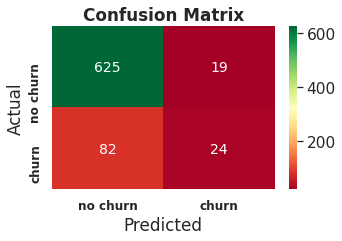


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 64, 8, 16, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                1088      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 8) 

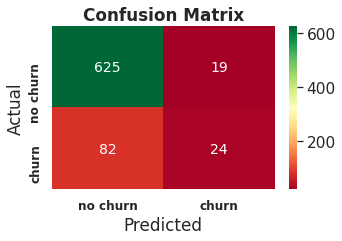


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (128, 64, 64, 128, 32) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 128)               2688      
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 

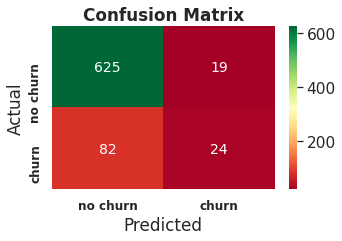


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750

 === Hidden layer size: (16, 16, 16, 128, 16) ===

Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 16)                272       
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 1

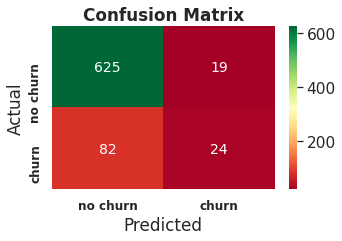


Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93       644
           1       0.56      0.23      0.32       106

    accuracy                           0.87       750
   macro avg       0.72      0.60      0.62       750
weighted avg       0.84      0.87      0.84       750



In [33]:
epochs = 50

scores_hidden_dict = dict()

for hidden_shape in test_comb:
    print(" === Hidden layer size:", hidden_shape, "===\n")

    scores = list()
    optimizer= Adam(0.0001)

    model_hidden = build_model(input_shape=20, hidden_shapes=hidden_shape, hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')
    model_hidden.summary()

    CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='multi_lay_rec_model.hdf5', save_best_only=True, mode='max', verbose=0)
    
    hist = model_hidden.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0, callbacks=[CB_checkpoint])
    
    model_hidden.load_weights('multi_lay_rec_model.hdf5')
    #scores_hidden_dict[hidden_shape] = hist.history['accuracy']
    
    y_pred = model_pre.predict(x_test)
    threshold = 0.5
    y_pred = np.where(y_pred<=threshold, 0, 1)
    
    plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
    print_classification_report(y_test, y_pred)
    del model_hidden